In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
def crop_center(img,crop_size):

    if type(crop_size) == tuple:
        crop_x,crop_y = crop_size
    elif type(crop_size) == int:
        crop_x = crop_size
        crop_y = crop_size
    
    y,x = img.shape[-2::]
    startx = x//2-(crop_x//2)
    starty = y//2-(crop_y//2)        

    return img[...,starty:starty+crop_y,startx:startx+crop_x]

In [3]:
#### ALL PARAMETERS DEFINED HERE ####

supervised = True
augment = False

# Data paths
data_path = Path(r"E:\dl_monalisa\Data\Actin_fixed_mltplSNR_30nm_2\dump")
noiseModelsDir = Path(r"E:\dl_monalisa\Data\Actin_fixed_mltplSNR_30nm_2\noise_models\final")

# Choose parameters
upsamp = 1
DataNoiseLvl = "all" # "all",list of int, or int
GMMNoiseLvl = "same"
bootstrapped = False
GMMsig = "avg" # "n2v" or "avg", used for not bootstrapped models only
normSignalToObs = True # put True if signal was normalized to observations when creating GMM
normGMM = True # put True if data was normalized to create the GMM

checkNoiseModelDisplay = True

clean = "avg" # "n2v" or "avg", used for supervised
display = True # display images or not
clip = -3 # False or clip value
registration = False

# Get noise model name
if GMMNoiseLvl == "same":
    GMMNoiseLvl = DataNoiseLvl
if isinstance(GMMNoiseLvl,list):
    GMMNoiseLvlstr = ''.join(str(GMMNoiseLvl).split(', '))[1:-1]
else:
    GMMNoiseLvlstr = GMMNoiseLvl

if bootstrapped:
    GMMname = f"GMM_Noise{GMMNoiseLvlstr}_bootstrapped_Clip{clip}"
else:
    GMMname = f"GMM_Noise{GMMNoiseLvlstr}_Sig{GMMsig.upper()}_Clip{clip}"

if normGMM:
    GMMname = f"{GMMname}_norm.npz"
else:
    GMMname = f"{GMMname}.npz"
print ("Noise model: ", GMMname)
assert os.path.exists(noiseModelsDir/GMMname)

# Load GMM
noise_model_params= np.load(str(noiseModelsDir / GMMname))
# noise_model_params = np.load(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\noise_models\final\GMM_Noise1234_SigN2V_Clip-3.npz")
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)

print(f"Upsamp: {upsamp}")
print(f"Supervised: {supervised}")
print(f"Noise level: {DataNoiseLvl}")
print(f"GMM noise level: {GMMNoiseLvl}")
print(f"Clean: {clean}")
print(f"GMM: {GMMname}")

# Training prm
patch_size = 64
gaussian_noise_std = None

# Training-specific
beta = 0.005 # loss = recon_loss + beta * kl_loss
batch_size=64
virtual_batch = 8
lr=5e-6
max_epochs = 500
steps_per_epoch=400
test_batch_size=10

# Model-specific
num_latents = 5
z_dims = [64]*int(num_latents)
blocks_per_layer = 8
batchnorm = True
free_bits = 1.0

# Model name for saving
if isinstance(DataNoiseLvl,list):
    DataNoiseLvlstr = ''.join(str(DataNoiseLvl).split(', '))[1:-1]
else:
    DataNoiseLvlstr = DataNoiseLvl
data_name = str(data_path).split("\\")[3]
if bootstrapped:
    sig = "boostrapped"
else:
    sig = GMMsig.upper()
modelName = f"{data_name}_Noise{DataNoiseLvlstr}_GMM{GMMNoiseLvl}_Clip{clip}_{num_latents}Lat_{blocks_per_layer}Blocks_betaKL{beta}"
if supervised:
    modelName = modelName + f"_Supervised{clean.upper()}"
if upsamp > 1:
    modelName = modelName + "_upsamp2random"
if not augment:
    modelName = modelName + "_NoAugment"

save_model_basedir = "./Trained_model/" 
print(f"Trained model will be saved at: {save_model_basedir}")
print(f"Model save name: {modelName}")


Noise model:  GMM_Noiseall_SigAVG_Clip-3_norm.npz
Upsamp: 1
Supervised: True
Noise level: all
GMM noise level: all
Clean: avg
GMM: GMM_Noiseall_SigAVG_Clip-3_norm.npz
Trained model will be saved at: ./Trained_model/
Model save name: Actin_fixed_mltplSNR_30nm_2_Noiseall_GMMall_Clip-3_5Lat_8Blocks_betaKL0.005_SupervisedAVG_NoAugment


In [4]:
##### Load data ####
crop_size = (1392,1392)
signal = []
observation = []
filters = ['tif','tiff']

files = os.listdir(data_path)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files.remove(f)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files.remove(f)

print(f"\nFound {len(files)} files.\n")

if isinstance(DataNoiseLvl,list) or DataNoiseLvl == "all":
    mltplNoise = True
else:
    mltplNoise = False


removing info.txt in signals because not in filters
removing Thumbs.db in signals because not in filters
Removing selected_data in observations because not in filters

Found 39 files.



In [7]:

for f in (files):

    # n2v or avg signal selection
    if clean == "avg":
        im_signal = np.mean(imread(data_path / f)[0:5],axis=0)
    else:
        raise ValueError("avg gt is the only one available for now for actin")
    
    # noise level selection
    if DataNoiseLvl == "all":
        im_obs  = imread(data_path / f)
    elif isinstance(DataNoiseLvl,int) or isinstance(DataNoiseLvl,list):
        im_obs = imread(data_path / f)[DataNoiseLvl]

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    if registration:
        if DataNoiseLvl == "all":
            print("Registration not available for all noise level yet")
        else:
            tf = StackReg.TRANSLATION
            sr = StackReg(tf)
            tmat = sr.register(ref=im_signal,mov=im_obs)
            tform = AffineTransform(matrix=tmat)
            im_obs = warp(im_obs, tform,order=0)

    im_obs = crop_center(im_obs,crop_size)
    im_signal = crop_center(im_signal,crop_size)
    
    observation.append(im_obs)
    signal.append(im_signal)

    print(f"File {f}: shape: {im_obs.shape}")

full_signal = []
full_obs = []
if mltplNoise:
    for i,obs in enumerate(observation):
        sig = signal[i]
        if normSignalToObs:
            sig = (sig - np.mean(sig))/np.std(sig)
        for frame in obs:
            if normSignalToObs:
                norm_sig = sig * np.std(frame) + np.mean(frame)
                full_signal.append(norm_sig)
            else:
                full_signal.append(sig)

            full_obs.append(frame)
    observation = np.stack(full_obs)
    signal = np.stack(full_signal)
else:
    observation = np.stack(observation)
    signal = np.stack(signal)


if signal.shape[-1] != signal.shape[-2]:
    print("Cropping to square")
    a = min(signal.shape[-1],signal.shape[-2])
    signal = signal [...,0:a,0:a]
    observation = observation [...,0:a,0:a]

if normGMM:
    signal = (signal - np.mean(observation)) / np.std(observation)
    observation = (observation - np.mean(observation)) / np.std(observation)

print("After normalization:")
print(f"Mean signal {np.mean(signal)}, std signal {np.std(signal)} ")
print(f"Mean observation {np.mean(observation)}, std observation {np.std(observation)} ")

print(f"\n\nConcatenated arrays:\tSignal: {signal.shape}\tObservation: {observation.shape}")

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(observation[0][400:800,400:800])
plt.title("Noisy")

plt.subplot(1,2,2)
plt.imshow(signal[0][400:800,400:800])
plt.title("Clean")

File 15h18timelapse.tiff: shape: (52, 1392, 1392)
File 15h55timelapse.tiff: shape: (96, 1392, 1392)
File 16h15timelapse.tiff: shape: (176, 1392, 1392)
File 17h05timelapse.tiff: shape: (116, 1392, 1392)
File 17h31timelapse.tiff: shape: (55, 1392, 1392)
File 18h25timelapse.tiff: shape: (104, 1392, 1392)
File 19h34timelapse.tiff: shape: (212, 1392, 1392)
File timelapse1.tiff: shape: (50, 1392, 1392)
File timelapse10.tiff: shape: (100, 1392, 1392)
File timelapse11.tiff: shape: (150, 1392, 1392)
File timelapse2.tiff: shape: (50, 1392, 1392)
File timelapse3.tiff: shape: (147, 1392, 1392)
File timelapse4.tiff: shape: (150, 1392, 1392)
File timelapse5.tiff: shape: (138, 1392, 1392)
File timelapse6.tiff: shape: (180, 1392, 1392)
File timelapse8.tiff: shape: (121, 1392, 1392)
File timelapse9.tiff: shape: (106, 1392, 1392)


ValueError: all input arrays must have the same shape

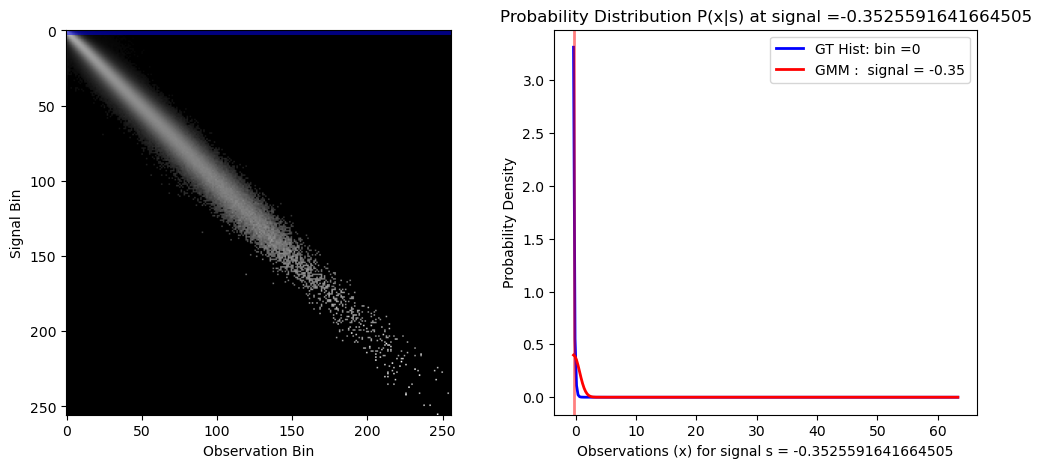

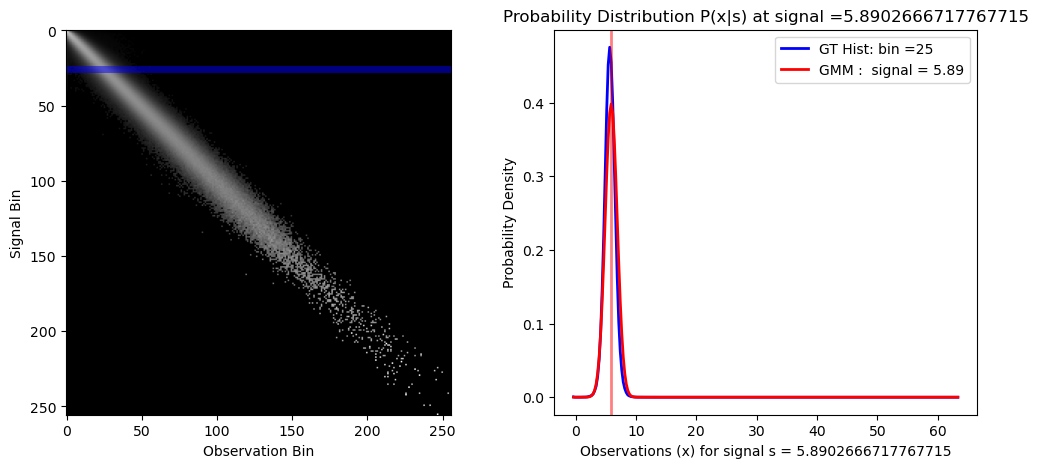

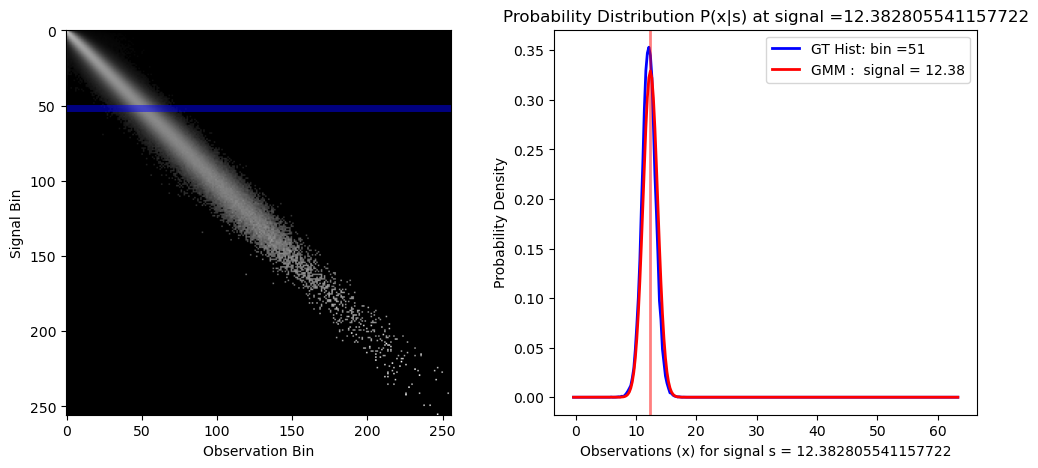

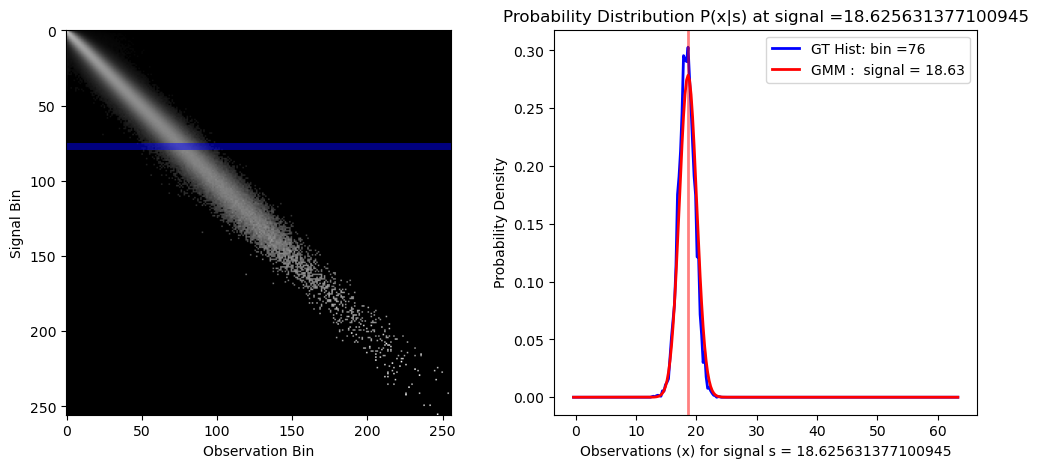

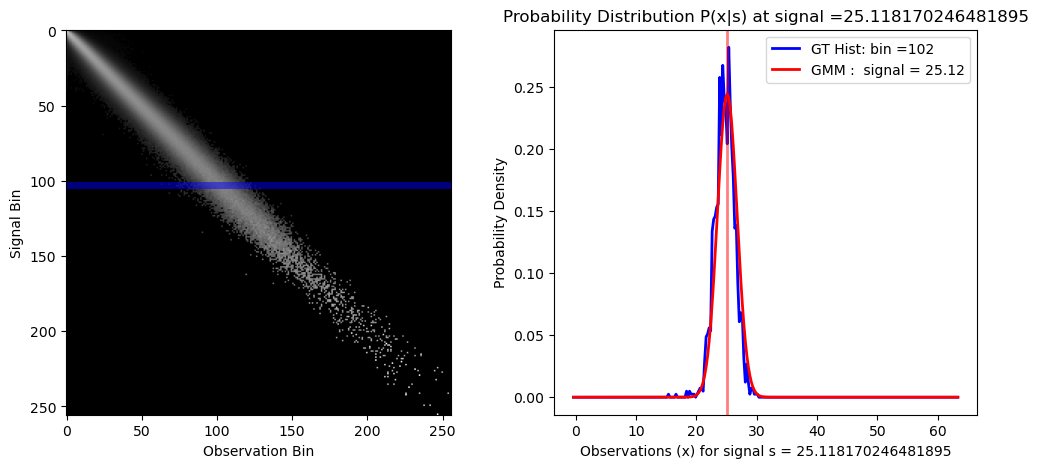

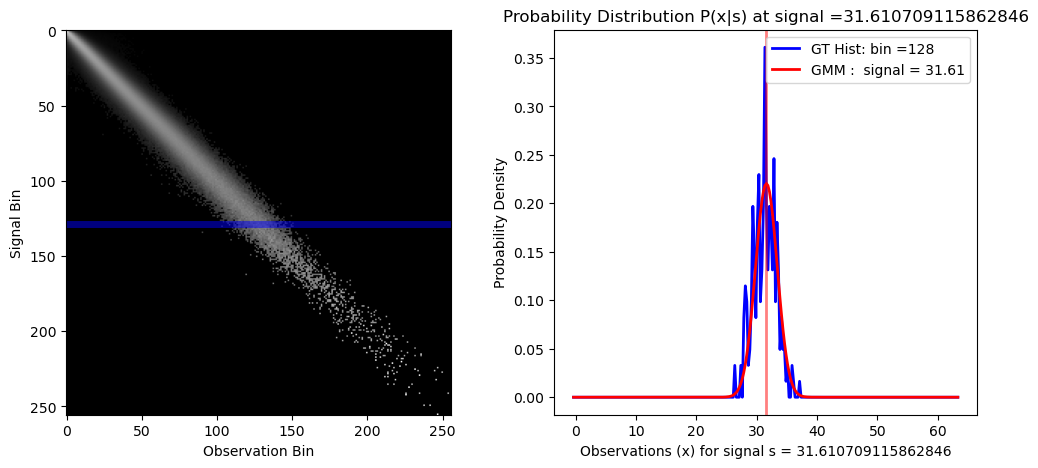

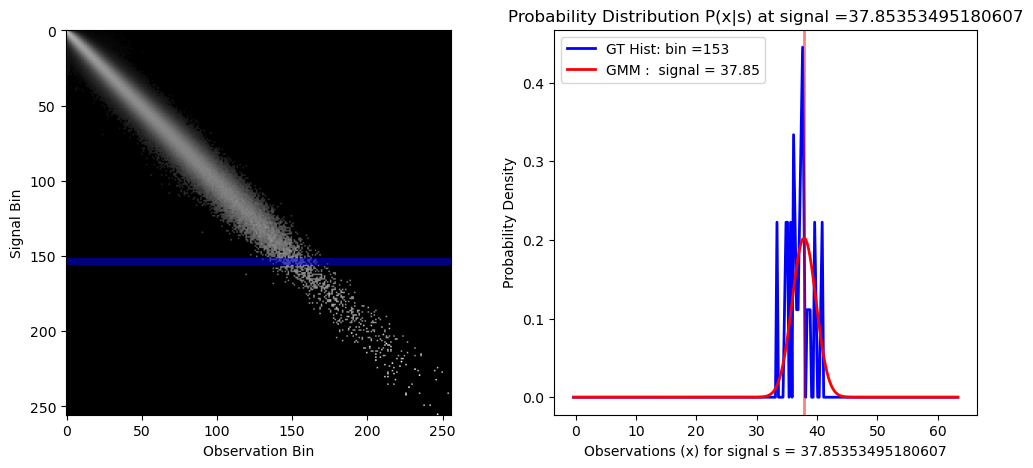

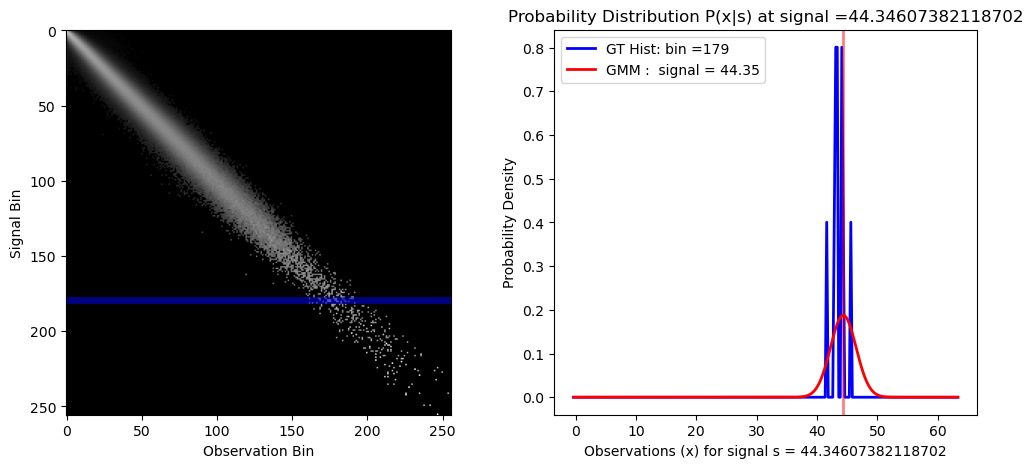

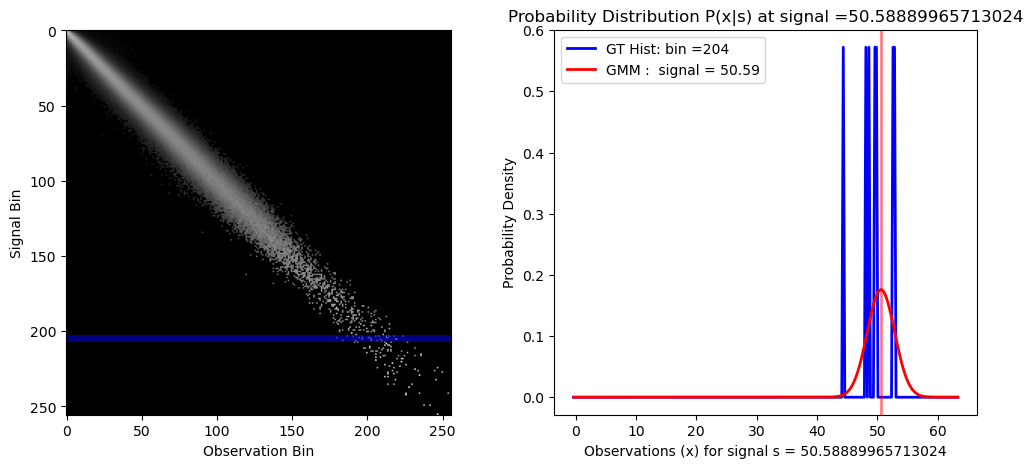

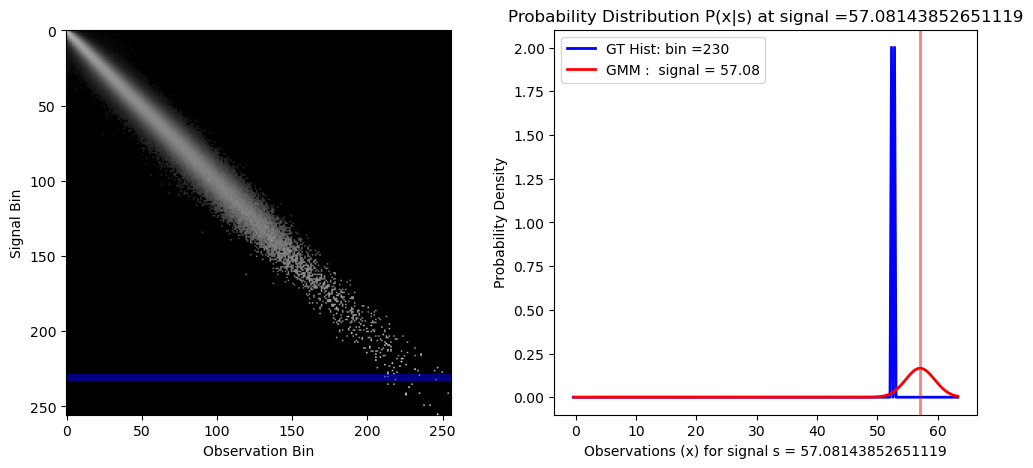

In [22]:
# Optional display of Noise Model with data histogram to check that it matches 
# NOTE: does not make sense for bootstrapped histogram!
n_points = 10
bins=256
minVal = np.min(signal)
maxVal =  np.max(signal)
if checkNoiseModelDisplay:
    histogram = histNoiseModel.createHistogram(bins, minVal,maxVal, observation,signal)
    signalBinIndex_list = (np.linspace(0,n_points-1,n_points)*bins//n_points).astype(int)

    for binidx in signalBinIndex_list:
        plotProbabilityDistribution(signalBinIndex=binidx, histogram=histogram[0], gaussianMixtureNoiseModel=noiseModel, min_signal=minVal, max_signal=maxVal, n_bin=bins, device=device)

In [23]:

# Split into train and val, define gt data if supervised

train_data = observation[:int(0.85*observation.shape[0])]
val_data= observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
if augment:
    train_data = utils.augment_data(train_data) ### Data augmentation disabled for fast training, but can be enabled
### Optional part with GT data if supervised###
# if supervised:
train_data_gt = signal[:int(0.85*observation.shape[0])]
val_data_gt = signal[int(0.85*observation.shape[0]):]
print("Shape of GT training images:", train_data.shape, "Shape of validation images:", val_data.shape)
if augment:
    train_data_gt = utils.augment_data(train_data_gt) ### Data augmentation disabled for fast training, but can be enabled

Shape of training images: (454, 1392, 1392) Shape of validation images: (81, 1392, 1392)
Shape of GT training images: (454, 1392, 1392) Shape of validation images: (81, 1392, 1392)


In [24]:
# Patches extraction

img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)

# if not supervised:
#     train_images = utils.extract_patches(train_data, patch_size, num_patches)
#     val_images = utils.extract_patches(val_data, patch_size, num_patches)
# else:
train_images,train_images_gt = utils.extract_patches_supervised(train_data,train_data_gt, patch_size, num_patches)
val_images,val_images_gt  = utils.extract_patches_supervised(val_data,val_data_gt, patch_size, num_patches)
    
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

100%|██████████| 81/81 [00:02<00:00, 35.45it/s]

Shape of training images: (214742, 64, 64) Shape of validation images: (38313, 64, 64)


In [25]:
# Patches selection
thresh = 0.05

# train
train_images_gt_norm = np.linalg.norm(train_images_gt,axis=(1,2))
train_images_gt_norm = train_images_gt_norm / train_images_gt_norm.max()
ind_norm = np.where(train_images_gt_norm > thresh)[0]

train_images_gt = train_images_gt[ind_norm,...]
train_images = train_images[ind_norm,...]

# val
val_images_gt_norm = np.linalg.norm(val_images_gt,axis=(1,2))
val_images_gt_norm = val_images_gt_norm / val_images_gt_norm.max()
ind_norm = np.where(val_images_gt_norm > thresh)[0]

val_images_gt = val_images_gt[ind_norm,...]
val_images = val_images[ind_norm,...]

In [26]:
# We limit validation patches to 1000 to speed up training but it is not necessary
val_images = val_images[:1000]
test_images = val_images[:100]
if supervised:
    val_images_gt = val_images_gt [:1000] 
    test_images_gt = val_images_gt[:100]

In [27]:
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

Shape of training images: (32266, 64, 64) Shape of validation images: (1000, 64, 64)


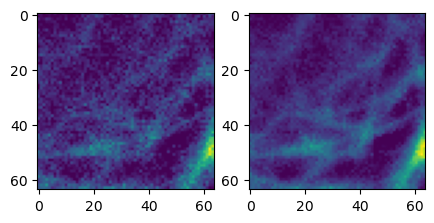

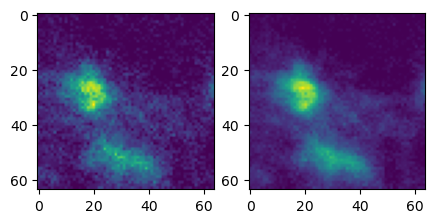

In [28]:
# if supervised: Display of paired dataset to check that it is matching 

if supervised:
    import random
    idx = random.randrange(train_images.shape[0])

    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(train_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(train_images_gt[idx])

    idx = random.randrange(val_images.shape[0])
    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(val_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(val_images_gt[idx])

In [29]:
# Choose make_data_manager for supervised training or make_data_manager 2 for supervised

if upsamp>1 or supervised:
    if not supervised:
        train_images_gt = train_images.copy()
        val_images_gt = val_images.copy()
        test_images_gt = test_images.copy()

    train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager_supervised(train_images,train_images_gt,val_images,
                                                                                            val_images_gt, test_images,test_images_gt,
                                                                                            batch_size,test_batch_size,upsamp=upsamp)

else:
    train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
                                                                                            test_images,batch_size,
                                                                                            test_batch_size)


# Here we ensure that steps_per_epoch not bigger than len(train_loader)
# It never goes into validation otherwise, and so it never saves the model.
steps_per_epoch=min(len(train_loader)-1,steps_per_epoch)
print(steps_per_epoch)

400


In [30]:
print(data_mean,data_std)

1.169395411824814 2.196248609260065


0
(64, 64)
1
(64, 64)
2
(64, 64)
3
(64, 64)
4
(64, 64)
5
(64, 64)
6
(64, 64)
(64, 64)


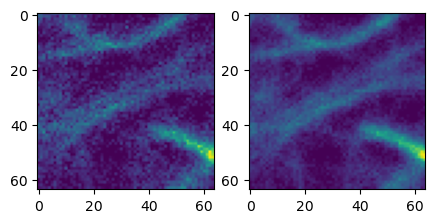

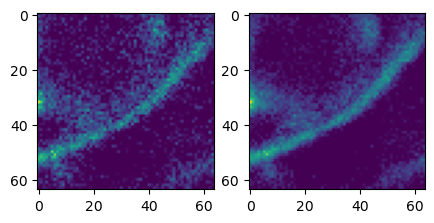

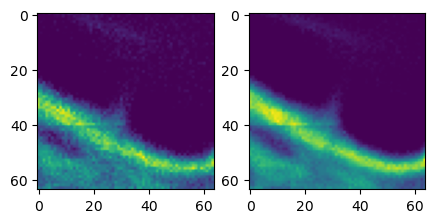

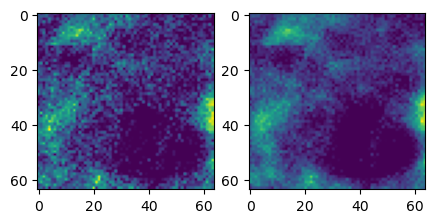

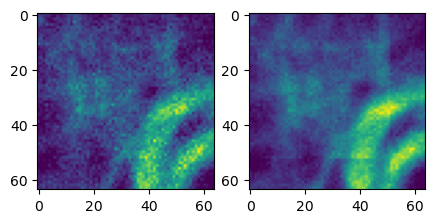

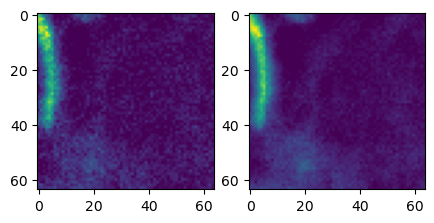

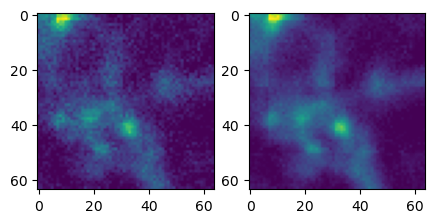

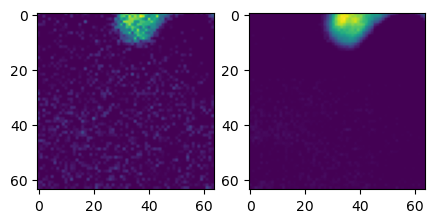

In [31]:


# if supervised: Display of paired dataset to check that it is still matching in the loader  

if supervised or upsamp > 1:
    for batch_idx, (x, y) in enumerate(train_loader):
        print(batch_idx)

        x2 = x.cpu().numpy()
        x2 = x2[0]
        print(x2.shape)

        y2 = y.cpu().numpy()
        y2 = y2[0]

        plt.figure(figsize=(5,5))
        plt.subplot(1,2,1)
        plt.imshow(x2)
        plt.subplot(1,2,2)
        plt.imshow(y2)
        if batch_idx > 5:
            break

    batch_idx, (x, y) = next(enumerate(val_loader))

    x2 = x.cpu().numpy()
    x2 = x2[0]
    print(x2.shape)

    y2 = y.cpu().numpy()
    y2 = y2[0]

    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(x2)
    plt.subplot(1,2,2)
    plt.imshow(y2)

In [32]:
# Train network


model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=save_model_basedir,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=modelName,val_loss_patience=100,beta=beta)

Epoch[1/500] Training Loss: 2.015 Reconstruction Loss: 2.007 KL Loss: 1.642
saving ./Trained_model/model/Actin_fixed_mltplSNR_30nm_2_Noiseall_GMMall_Clip-3_5Lat_8Blocks_betaKL0.005_SupervisedAVG_NoAugment_last_vae.net
saving ./Trained_model/model/Actin_fixed_mltplSNR_30nm_2_Noiseall_GMMall_Clip-3_5Lat_8Blocks_betaKL0.005_SupervisedAVG_NoAugment_best_vae.net
Patience: 0 Validation Loss: 2.0786778926849365 Min validation loss: 2.0786778926849365
Time for epoch: 554seconds
Est remaining time: 3 days, 4:47:26 or 276446 seconds
----------------------------------------
Epoch[2/500] Training Loss: 1.605 Reconstruction Loss: 1.596 KL Loss: 1.788
saving ./Trained_model/model/Actin_fixed_mltplSNR_30nm_2_Noiseall_GMMall_Clip-3_5Lat_8Blocks_betaKL0.005_SupervisedAVG_NoAugment_last_vae.net
saving ./Trained_model/model/Actin_fixed_mltplSNR_30nm_2_Noiseall_GMMall_Clip-3_5Lat_8Blocks_betaKL0.005_SupervisedAVG_NoAugment_best_vae.net
Patience: 0 Validation Loss: 2.0369436740875244 Min validation loss: 2

KeyboardInterrupt: 

# Plotting losses

In [ ]:
directory_path = "./Trained_model/" 
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

In [ ]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()